# Data Analysis

## Global Imports

In [1]:
import numpy as np
import pandas as pd

## Functions

### Data access functions

In [2]:
from pathlib import Path


def data(root: Path) -> Path:
    return root / "data"


def output(root: Path) -> Path:
    return data(root) / "output"


def raw_results(root: Path) -> Path:
    return data(root) / "raw_results" / "raw_results.csv"


def subjects(root: Path) -> Path:
    return data(root) / "raw_results" / "subjects.csv"


def commits(root: Path) -> Path:
    return data(root) / "raw_results" / "commits.csv"


def truth(root: Path) -> Path:
    return data(root) / "truth" / "truth.csv"


### Function to summarize DataFrame

In [3]:
from collections.abc import Callable, Sequence
from dataclasses import dataclass


MetricFn = Callable[[pd.DataFrame], object]


def _require_cols(g: pd.DataFrame, cols: Sequence[str]) -> None:
    missing = [c for c in cols if c not in g.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")


# ---------------------------------------------------------------------
# Metrics
# ---------------------------------------------------------------------
def m_n_subjects(g: pd.DataFrame) -> int:
    return int(len(g))


def m_n_repos(g: pd.DataFrame) -> int:
    _require_cols(g, ["full_name_of_repo"])
    return int(g["full_name_of_repo"].nunique())


def m_n_commits(g: pd.DataFrame) -> int:
    _require_cols(g, ["commit_sha"])
    return int(g["commit_sha"].nunique())


def m_n_distinct_paths(g: pd.DataFrame) -> int:
    _require_cols(g, ["path"])
    return int(g["path"].nunique())


def m_positive_rate(g: pd.DataFrame) -> float:
    _require_cols(g, ["is_ccdc_event"])
    n = len(g)
    return np.nan if n == 0 else float(g["is_ccdc_event"].sum() / n)


def m_n_distinct_channels(g: pd.DataFrame) -> int:
    _require_cols(g, ["detected_channels"])
    return int(
        g["detected_channels"]
        .explode()
        .dropna()
        .nunique()
    )


# ---------------------------------------------------------------------
# Registry: metric_name -> (fn, required_columns)
# ---------------------------------------------------------------------
METRICS: dict[str, tuple[MetricFn, tuple[str, ...]]] = {
    "n_subjects": (m_n_subjects, ()),
    "n_repos": (m_n_repos, ("full_name_of_repo",)),
    "n_commits": (m_n_commits, ("commit_sha",)),
    "n_distinct_paths": (m_n_distinct_paths, ("path",)),
    "positive_rate": (m_positive_rate, ("is_ccdc_event",)),
    "n_distinct_channels": (
        m_n_distinct_channels,
        ("detected_channels",),
    ),
}


# ---------------------------------------------------------------------
# Configuration
# ---------------------------------------------------------------------
@dataclass(frozen=True)
class SummarizeConfig:
    include_metrics: tuple[str, ...]
    group_keys: tuple[str, ...] = ()
    forbid_access_to_group_keys: bool = True
    drop_group_keys_from_frame: bool = True
    deny_columns: tuple[str, ...] = ()


# ---------------------------------------------------------------------
# Core summarization
# ---------------------------------------------------------------------
def summarize_subjects_configurable(
    g: pd.DataFrame,
    cfg: SummarizeConfig,
) -> pd.Series:

    g_eff = (
        g.drop(columns=list(cfg.group_keys), errors="ignore")
        if cfg.drop_group_keys_from_frame and cfg.group_keys
        else g
    )

    forbidden = set(cfg.deny_columns)
    if cfg.forbid_access_to_group_keys:
        forbidden |= set(cfg.group_keys)

    out: dict[str, object] = {}

    for name in cfg.include_metrics:
        if name not in METRICS:
            raise KeyError(
                f"Unknown metric: {name}. "
                f"Known: {sorted(METRICS)}"
            )

        fn, required = METRICS[name]

        illegal = [c for c in required if c in forbidden]
        if illegal:
            raise ValueError(
                f"Metric '{name}' requires forbidden columns {illegal}. "
                f"Forbidden: {sorted(forbidden)}"
            )

        out[name] = fn(g_eff)

    return pd.Series(out)

### Tupel with each and every available metric

In [4]:
ALL_METRICS = (
    "n_subjects",
    "n_repos",
    "n_commits",
    "n_distinct_paths",
    "positive_rate",
    "n_distinct_channels",
)

### Function to cast columns of DataFrame to Int64

In [5]:
from collections.abc import Iterable

def col_to_int(df: pd.DataFrame, int_cols: Iterable[str]) -> pd.DataFrame:
    cols = [c for c in int_cols if c in df.columns]
    df[cols] = df[cols].astype("Int64")
    return df

#### "Popular" Int64 columns

In [6]:
INT_COLS_OF_SUMMARY = [
    "n_subjects",
    "n_repos",
    "n_commits",
    "n_distinct_paths",
    "n_distinct_channels",
]

INT_COLS_OF_VC_STATS = [
    "n_categories",
    "total_count",
    "min_count",
    "max_count",
    "median_count",
    "q1_count",
    "q3_count",
    "iqr_count",
    "top_1_count",
]

### Distribution Functions (for a pd.Series)

In [7]:
def distribution_stats(
    s: pd.Series,
    *,
    prefix: str = "",
    dropna: bool = True,
) -> pd.Series:
    """
    Core descriptive stats for a numeric series, including boxplot whiskers/outliers.
    Works for both raw numeric data and 'counts per category' (value_counts output values).
    """
    if dropna:
        s = s.dropna()

    if s.empty:
        return pd.Series(dtype="float64")

    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return pd.Series(dtype="float64")

    q1 = s.quantile(0.25)
    q2 = s.quantile(0.50)
    q3 = s.quantile(0.75)
    iqr = q3 - q1

    # Handle iqr=0 robustly (all values equal) without producing empty slices
    if pd.isna(iqr) or iqr == 0:
        lower_whisker = s.min()
        upper_whisker = s.max()
        n_outliers = 0
    else:
        lo = q1 - 1.5 * iqr
        hi = q3 + 1.5 * iqr
        lower_whisker = s[s >= lo].min()
        upper_whisker = s[s <= hi].max()
        n_outliers = int(((s < lower_whisker) | (s > upper_whisker)).sum())

    def k(name: str) -> str:
        return f"{prefix}{name}" if prefix else name

    return pd.Series({
        k("n"): int(len(s)),
        k("min"): float(s.min()),
        k("max"): float(s.max()),
        k("mean"): float(s.mean()),
        k("median"): float(q2),
        k("q1"): float(q1),
        k("q3"): float(q3),
        k("iqr"): float(iqr),
        k("lower_whisker"): float(lower_whisker),
        k("upper_whisker"): float(upper_whisker),
        k("n_outliers"): int(n_outliers),
    })


def boxplot_stats(s: pd.Series) -> pd.Series:
    # Now just a thin wrapper around the shared core
    return distribution_stats(s)


def value_counts_stats(vc: pd.Series) -> pd.Series:
    """
    Stats for a value_counts() result: distribution stats of the counts + concentration metrics.
    Expects vc to be sorted descending (as value_counts() returns by default).
    """
    vc = vc.dropna()
    if vc.empty:
        return pd.Series(dtype="float64")

    total = int(vc.sum())
    n_categories = int(len(vc))

    # shared distribution/boxplot stats over "counts per category"
    core = distribution_stats(vc, prefix="count_")

    # concentration / dominance (requires descending order)
    top_1 = int(vc.iloc[0])
    top_5_sum = int(vc.iloc[:5].sum())
    top_10_sum = int(vc.iloc[:10].sum())

    conc = pd.Series({
        "n_categories": n_categories,
        "total_count": total,
        "top_1_count": top_1,
        "top_1_share": (top_1 / total) if total else float("nan"),
        "top_5_share": (top_5_sum / total) if total else float("nan"),
        "top_10_share": (top_10_sum / total) if total else float("nan"),
    })

    return pd.concat([conc, core])

## Data Preparation

### Reading the raw data

In [8]:
raw_data = pd.read_csv(
    raw_results(Path.cwd()),
    low_memory=False,
)

### Working with a copy of the raw data

In [9]:
data = raw_data.copy()

### Droping unnecessary columns / Keeping interesting ones

I have decided not to analyse the snapshot data of a repo. Why not? Because it is snapshot data for the point in time when I gathered the data. If a repo "has GitHub discussions", I have no idea since when that is the case. What if I draw conclusions when actually GitHub discussions has been introduced for that repo just the day before pulling the data?

In [10]:
COLS_OF_INTEREST = [
    "full_name_of_repo",
    "commit_sha",
    "path",
    "is_ccdc_event",
    "detected_channel",
    "created_at",
    "pushed_at",
    "updated_at",
    "date",
]

UNNECESSARY_COLS = []

for col in data.columns:
    if col not in COLS_OF_INTEREST:
        UNNECESSARY_COLS.append(col)

data.drop(columns=UNNECESSARY_COLS, inplace=True)

### Data conversion – if needed

In [11]:
def to_bool(series: pd.Series) -> pd.Series:
    if series.dtype == bool:
        return series
    s = series.astype("string").str.strip().str.lower()
    mapping = {"true": True, "false": False}
    return s.map(mapping)


data["is_ccdc_event"] = to_bool(data["is_ccdc_event"])

data["detected_channel"] = data["detected_channel"].astype("string").fillna("")

DATETIME_COLS = ["created_at", "pushed_at", "updated_at", "date"]

for col in DATETIME_COLS:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors="coerce", utc=True)


### Removing channels of negatives

In [12]:
data["detected_channel"] = (
    data["detected_channel"]
        .where(data["is_ccdc_event"] == True, "")
)

### Channel aggregation – Introducing the subjects dataframe

Objective: One row = one subject

In [13]:
KEY_COLS = [
    "full_name_of_repo",
    "commit_sha",
    "path",
]

gb = data.groupby(KEY_COLS, dropna=False)


def agg_channels(x: pd.Series) -> tuple[str, ...]:
    vals = [
        v
        for v in x.astype("string").tolist()
        if isinstance(v, str) and v.strip() != ""
    ]
    return tuple(sorted(set(vals)))


agg = gb.agg(
    is_ccdc_event=("is_ccdc_event", "first"),
    detected_channels=("detected_channel", agg_channels),
)

for col in COLS_OF_INTEREST:
    if col not in KEY_COLS and col not in agg.columns and col != "detected_channel":
        agg[col] = gb[col].first()

subjects = agg.reset_index()

### Adding "first_activity" column

The first activity is the timestamp that is earlier: the commit or when the repo was officially created.

In [14]:
subjects["first_activity"] = (
    subjects[["date", "created_at"]]
        .min(axis=1)
        .groupby(subjects["full_name_of_repo"], dropna=False)
        .transform("min")
)

### Adding "repo_age" column

In [15]:
subjects["repo_age"] = (
    (subjects["date"] - subjects["first_activity"]).to_numpy()
    / np.timedelta64(1, "D")
)

subjects.sort_values(["full_name_of_repo", "repo_age"], inplace=True)
subjects.reset_index(drop=True, inplace=True)

### Adding "repo_age_group" column

In [16]:
AGE_GROUPS = [
    (0, 1, "0-1"),
    (1, 2, "1-2"),
    (2, 3, "2-3"),
    (3, 4, "3-4"),
    (4, 5, "4-5"),
    (5, 6, "5-6"),
    (6, 7, "6-7"),
    (7, 8, "7-8"),
    (8, 9, "8-9"),
    (9, 10, "9-10"),
    (10, 11, "10-11"),
    (11, 12, "11-12"),
    (12, 13, "12-13"),
    (13, 14, "13-14"),
    (14, 15, "14-15"),
    (15, 999, "15+"),
]


def assign_age_group(age_in_days: float) -> int | None:
    if pd.isna(age_in_days):
        return None
    for lo, hi, label in AGE_GROUPS:
        if lo * 365.25 <= age_in_days < hi * 365.25:
            return lo
    return None


subjects["repo_age_group"] = subjects["repo_age"].apply(assign_age_group)

### Adding "year" column for temporal analysis

In [17]:
subjects["year"] = subjects["date"].dt.year

### Extracting a dedicated repos dataframe

In [18]:
repos = (
    subjects
        .groupby("full_name_of_repo", as_index=False)
        .agg(
            first_subject_at=("date", "min"),
            created_at=("created_at", "first"),
            first_activity=("first_activity", "first"),
            pushed_at=("pushed_at", "first"),
            updated_at=("updated_at", "first"),
        )
)

subjects.drop(
    columns=["created_at", "pushed_at", "updated_at", "first_activity"],
    inplace=True,
)

In [19]:
repos["last_activity"] = repos[["pushed_at", "updated_at"]].max(axis=1)

repos["lifespan"] = (
    (repos["last_activity"] - repos["first_activity"]).to_numpy()
    / np.timedelta64(1, "D")
)

repos["age_group"] = repos["lifespan"].apply(assign_age_group)

repos["days_until_first_subject"] = (
    (repos["first_subject_at"] - repos["first_activity"]).to_numpy()
    / np.timedelta64(1, "D")
)
repos["age_group_at_first_subject"] = repos["days_until_first_subject"].apply(assign_age_group)

repos.sort_values("full_name_of_repo", ascending=False, inplace=True)
repos.reset_index(drop=True, inplace=True)

### Creating a years dataframe

In [20]:
earliest_activity = repos["first_activity"].min()
most_recent_activity = repos["last_activity"].max()

years = pd.DataFrame({
    "year": range(
        earliest_activity.year,
        most_recent_activity.year + 1,
    )
})

years.set_index("year", inplace=True)

In [21]:
years

""
year
2008
2009
2010
2011
2012
2013
2014
2015
2016


#### Alternative

In [22]:
# years = (
#     pd.date_range(
#         start=earliest_activity,
#         end=most_recent_activity,
#         freq="YS",   # Year Start
#     )
#     .year
#     .to_frame(name="year")
# )

In [23]:
print(earliest_activity)
print(most_recent_activity)

2008-08-04 11:09:52+00:00
2026-01-13 12:31:44+00:00


## Descriptive Statistics

### Data Overview – How many?!

In [24]:
group_keys = []
cfg = SummarizeConfig(
    include_metrics=ALL_METRICS,
    group_keys=tuple(group_keys),
)

summary = summarize_subjects_configurable(subjects, cfg).to_frame().T

summary = col_to_int(summary, INT_COLS_OF_SUMMARY)

In [25]:
summary

,n_subjects,n_repos,n_commits,n_distinct_paths,positive_rate,n_distinct_channels
0,17694,364,17523,5,0.204928,33


### Data Overview – Describing the time period

In [26]:
min_date = subjects["date"].min()
max_date = subjects["date"].max()
time_period_in_days = (max_date - min_date).to_numpy() / np.timedelta64(1, "D")

print(f"The first commit took place at {min_date}")
print(f"The last commit took place at {max_date}")
print(f"The time period spans {time_period_in_days} days.")

The first commit took place at 2008-08-04 11:09:52+00:00
The last commit took place at 2025-12-30 15:55:36+00:00
The time period spans 6357.198425925926 days.


In [27]:
print("How many days does a project get to live?")
print(boxplot_stats(repos["lifespan"]))

How many days does a project get to live?
n                 364.000000
min                32.847535
max              6370.309502
mean             3594.960037
median           3658.692737
q1               3118.432905
q3               4240.123281
iqr              1121.690376
lower_whisker    1442.861840
upper_whisker    5830.789792
n_outliers         21.000000
dtype: float64


In [28]:
repos_copy = repos.copy()

repos_copy["year_of_first_activity"] = repos_copy["first_activity"].dt.year

group_keys = ["year_of_first_activity"]

cfg = SummarizeConfig(
    include_metrics=(
        "n_repos",
    ),
    group_keys=tuple(group_keys),
)

repos_born_in = (
    repos_copy
        .groupby(group_keys)[["full_name_of_repo"]]
        .apply(lambda g: summarize_subjects_configurable(g, cfg))
)

repos_born_in = years.join(
    repos_born_in.rename_axis("year"),
    how="left"
)

repos_born_in["n_repos"] = repos_born_in["n_repos"].fillna(0).astype(int)

repos_born_in = repos_born_in.rename(columns={"n_repos": "n_repos_born_in"})

In [29]:
cc = repos.copy()

cc["last_activity_year"] = cc["last_activity"].dt.year

group_keys = ["last_activity_year"]

cfg = SummarizeConfig(
    include_metrics=(
        "n_repos",
    ),
    group_keys=tuple(group_keys),
)

repos_died_in = (
    cc
        .groupby(group_keys)[["full_name_of_repo"]]
        .apply(lambda g: summarize_subjects_configurable(g, cfg))
)

repos_died_in = years.join(
    repos_died_in.rename_axis("year"),
    how="left"
)

repos_died_in["n_repos"] = repos_died_in["n_repos"].fillna(0).astype(int)

repos_died_in = repos_died_in.rename(columns={"n_repos": "n_repos_died_in"})

In [30]:
repos_lifetime = repos_born_in.join(
    repos_died_in,
    how="left",
)

In [31]:
repos_lifetime

,n_repos_born_in,n_repos_died_in
year,,
2008,1,0
2009,4,0
2010,6,0
2011,4,0
2012,28,0
2013,44,0
2014,72,0
2015,66,2
2016,68,2


In [32]:
print(f"How many repos are still active in 2025? Answer: {len(repos[repos["last_activity"].dt.year >= 2025])}")

How many repos are still active in 2025? Answer: 294


In [33]:
group_keys = ["age_group"]

cfg = SummarizeConfig(
    include_metrics=(
        "n_repos",
    ),
    group_keys=tuple(group_keys),
)

n_repos_per_age_group = (
    repos
        .groupby(group_keys)[["full_name_of_repo"]]
        .apply(lambda g: summarize_subjects_configurable(g, cfg))
        .sort_index()
)

n_repos_per_age_group["n_survivors"] = n_repos_per_age_group["n_repos"][::-1].cumsum()[::-1]

n_repos_per_age_group = n_repos_per_age_group.rename(columns={"n_repos": "n_repos_per_age_group"})

In [34]:
n_repos_per_age_group

,n_repos_per_age_group,n_survivors
age_group,,
0,8,364
1,4,356
2,4,352
3,3,348
4,7,345
5,6,338
6,4,332
7,27,328
8,53,301


In [35]:
group_keys = ["age_group_at_first_subject"]

cfg = SummarizeConfig(
    include_metrics=(
        "n_repos",
    ),
    group_keys=tuple(group_keys),
)

repo_age_at_first_subject = (
    repos
        .groupby(group_keys)[["full_name_of_repo"]]
        .apply(lambda g: summarize_subjects_configurable(g, cfg))
)

In [36]:
repo_age_at_first_subject

,n_repos
age_group_at_first_subject,
0,339
1,6
2,9
3,4
5,1
6,2
7,1
8,2


### Data Overview – Subjects grouped by repo

In [37]:
group_keys = ["full_name_of_repo"]

cfg = SummarizeConfig(
    include_metrics=(
        "n_subjects",
        "n_commits",
        "n_distinct_paths",
        "positive_rate",
        "n_distinct_channels",
    ),
    group_keys=tuple(group_keys),
)

repo_summaries = (
    subjects
        .groupby(group_keys)[["commit_sha", "path", "is_ccdc_event", "detected_channels"]]
        .apply(lambda g: summarize_subjects_configurable(g, cfg))
)

repo_summaries = col_to_int(repo_summaries, INT_COLS_OF_SUMMARY)
repo_summaries.sort_values("n_subjects", ascending=False, inplace=True)

In [38]:
repo_summaries

,n_subjects,n_commits,n_distinct_paths,positive_rate,n_distinct_channels
full_name_of_repo,,,,,
spencermountain/compromise,570,565,2,0.150877,8
flexera-public/policy_templates,506,502,2,0.150198,9
plotly/plotly.js,367,365,2,0.130790,12
apache/shardingsphere,348,344,2,0.212644,14
danieleteti/delphimvcframework,331,331,1,0.190332,16
...,...,...,...,...,...
lessworks/translation,1,1,1,0.000000,0
mackmobile/Contador,1,1,1,0.000000,0
hwdtech/smartforms,1,1,1,0.000000,0


In [39]:
print(boxplot_stats(repo_summaries["n_subjects"]))

n                364.00000
min                1.00000
max              570.00000
mean              48.60989
median            25.50000
q1                12.00000
q3                59.00000
iqr               47.00000
lower_whisker      1.00000
upper_whisker    124.00000
n_outliers        28.00000
dtype: float64


In [40]:
print(f"The 28 outliers RE the subjects count are responsible for {repo_summaries.head(28)["n_subjects"].sum()} subjects…")

The 28 outliers RE the subjects count are responsible for 6452 subjects…


In [41]:
print(boxplot_stats(repo_summaries["n_distinct_paths"]))

n                364.000000
min                1.000000
max                3.000000
mean               1.324176
median             1.000000
q1                 1.000000
q3                 2.000000
iqr                1.000000
lower_whisker      1.000000
upper_whisker      3.000000
n_outliers         0.000000
dtype: float64


In [42]:
print(boxplot_stats(repo_summaries["positive_rate"]))

n                364.000000
min                0.000000
max                1.000000
mean               0.219142
median             0.201351
q1                 0.078441
q3                 0.307692
iqr                0.229251
lower_whisker      0.000000
upper_whisker      0.611111
n_outliers        15.000000
dtype: float64


In [43]:
print(boxplot_stats(repo_summaries["n_distinct_channels"]))

n                364.00000
min                0.00000
max               17.00000
mean               3.60989
median             2.00000
q1                 0.00000
q3                 6.00000
iqr                6.00000
lower_whisker      0.00000
upper_whisker     15.00000
n_outliers         6.00000
dtype: float64


### Data Overview – Subjects grouped by path

In [44]:
group_keys = ["path"]

cfg = SummarizeConfig(
    include_metrics=(
        "n_subjects",
        "n_repos",
        "n_commits",
        "positive_rate",
        "n_distinct_channels",
    ),
    group_keys=tuple(group_keys),
)

path_summaries = (
    subjects
        .groupby(group_keys)[["full_name_of_repo", "commit_sha", "is_ccdc_event", "detected_channels"]]
        .apply(lambda g: summarize_subjects_configurable(g, cfg))
)

path_summaries = col_to_int(path_summaries, INT_COLS_OF_SUMMARY)
path_summaries.sort_values("n_subjects", ascending=False, inplace=True)

In [45]:
path_summaries

,n_subjects,n_repos,n_commits,positive_rate,n_distinct_channels
path,,,,,
README.md,16172,355,16172,0.195709,32
CONTRIBUTING.md,909,99,909,0.333333,30
readme.md,412,10,412,0.274272,15
README.txt,174,15,174,0.229885,11
contributing.md,27,3,27,0.185185,2


### Data Overview – Detected channels

In [46]:
channel_counts = (
    subjects["detected_channels"]
        .explode()
        .dropna()
        .value_counts()
)

In [47]:
n = 10

top_n = channel_counts.head(n)
bottom_n = channel_counts.tail(n)

In [48]:
top_n

detected_channels
issues            367
mail              344
form              339
website           336
pull_request      334
forum             305
fork              267
mailing_list      185
github_issues     178
ping_on_github    148
Name: count, dtype: int64

In [49]:
bottom_n

detected_channels
facebook        35
google_group    27
patreon         16
youtube         12
medium           6
meetup           5
reddit           5
skype            3
newsletter       3
zulip            1
Name: count, dtype: int64

In [50]:
channel_stats = value_counts_stats(channel_counts)

channel_stats_df = col_to_int(channel_stats.to_frame().T, INT_COLS_OF_VC_STATS)

In [51]:
channel_stats

n_categories             33.000000
total_count            3806.000000
top_1_count             367.000000
top_1_share               0.096427
top_5_share               0.451918
top_10_share              0.736469
count_n                  33.000000
count_min                 1.000000
count_max               367.000000
count_mean              115.333333
count_median             61.000000
count_q1                 27.000000
count_q3                178.000000
count_iqr               151.000000
count_lower_whisker       1.000000
count_upper_whisker     367.000000
count_n_outliers          0.000000
dtype: float64

In [52]:
channel_stats_df

,n_categories,total_count,top_1_count,top_1_share,top_5_share,top_10_share,count_n,count_min,count_max,count_mean,count_median,count_q1,count_q3,count_iqr,count_lower_whisker,count_upper_whisker,count_n_outliers
0,33,3806,367,0.096427,0.451918,0.736469,33.0,1.0,367.0,115.333333,61.0,27.0,178.0,151.0,1.0,367.0,0.0


## Temporal Trends

### Yearly summary

In [53]:
group_keys = ["year"]

cfg = SummarizeConfig(
    include_metrics=ALL_METRICS,
    group_keys=tuple(group_keys),
)

yearly_summary = (
    subjects
        .groupby(group_keys)[["full_name_of_repo", "commit_sha", "path", "is_ccdc_event", "detected_channels"]]
        .apply(lambda g: summarize_subjects_configurable(g, cfg))
)

yearly_summary = col_to_int(yearly_summary, INT_COLS_OF_SUMMARY)

In [54]:
yearly_summary

,n_subjects,n_repos,n_commits,n_distinct_paths,positive_rate,n_distinct_channels
year,,,,,,
2008,6,1,6,1,0.166667,3
2009,34,2,34,2,0.117647,2
2010,59,6,58,2,0.152542,8
2011,52,9,51,2,0.173077,5
2012,246,26,244,4,0.231707,9
2013,644,71,643,4,0.256211,20
2014,1459,123,1441,4,0.210418,26
2015,1941,175,1919,5,0.210716,23
2016,2935,219,2910,5,0.191482,27


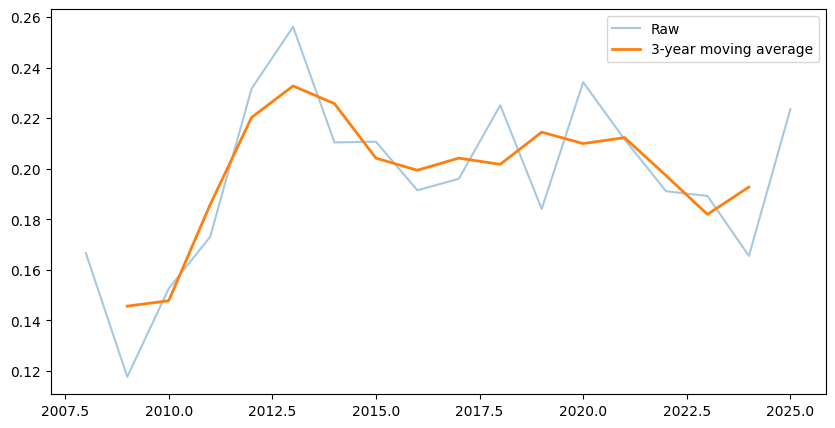

In [55]:
import matplotlib.pyplot as plt

yearly_summary["ma_3"] = yearly_summary["positive_rate"].rolling(3, center=True).mean()

plt.figure(figsize=(10,5))
plt.plot(yearly_summary.index, yearly_summary["positive_rate"], alpha=0.4, label="Raw")
plt.plot(yearly_summary.index, yearly_summary["ma_3"], linewidth=2, label="3-year moving average")
plt.legend()
plt.show()

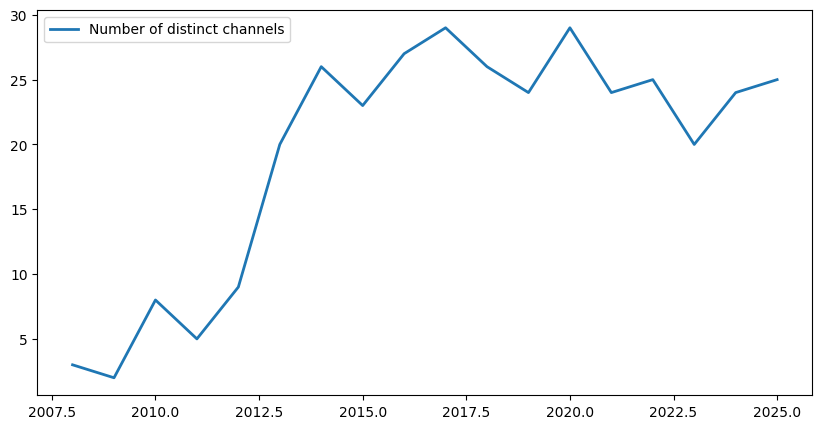

In [56]:
plt.figure(figsize=(10,5))
plt.plot(yearly_summary.index, yearly_summary["n_distinct_channels"], linewidth=2, label="Number of distinct channels")
plt.legend()
plt.show()

## Project Lifecycle Analysis

### All subjects

In [57]:
group_keys = ["repo_age_group"]

cfg = SummarizeConfig(
    include_metrics=ALL_METRICS,
    group_keys=tuple(group_keys),
)

summary_per_repo_age_group = (
    subjects
        .groupby(group_keys)[["full_name_of_repo", "commit_sha", "path", "is_ccdc_event", "detected_channels"]]
        .apply(lambda g: summarize_subjects_configurable(g, cfg))
)

summary_per_repo_age_group = col_to_int(summary_per_repo_age_group, INT_COLS_OF_SUMMARY)

summary_per_repo_age_group.reset_index(inplace=True)

summary_per_repo_age_group = (
    summary_per_repo_age_group
        .merge(
            right=n_repos_per_age_group.reset_index(),
            how="left",
            left_on="repo_age_group",
            right_on="age_group",
        )
)

summary_per_repo_age_group["active_repos_rate"] = (
    summary_per_repo_age_group["n_repos"] / summary_per_repo_age_group["n_survivors"]
)

In [58]:
summary_per_repo_age_group

,repo_age_group,n_subjects,n_repos,n_commits,n_distinct_paths,positive_rate,n_distinct_channels,age_group,n_repos_per_age_group,n_survivors,active_repos_rate
0,0,6397,339,6335,5,0.205878,32,0,8,364,0.931319
1,1,2430,251,2421,4,0.212346,27,1,4,356,0.705056
2,2,1995,216,1978,4,0.202506,26,2,4,352,0.613636
3,3,1439,211,1423,5,0.191800,26,3,3,348,0.606322
4,4,1214,173,1198,5,0.215815,25,4,7,345,0.501449
5,5,1024,138,1020,5,0.230469,25,5,6,338,0.408284
6,6,895,124,880,4,0.175419,24,6,4,332,0.373494
7,7,674,114,666,5,0.183976,23,7,27,328,0.347561
8,8,586,92,578,3,0.191126,23,8,53,301,0.305648
9,9,377,82,364,3,0.238727,24,9,66,248,0.330645


### Positives only

In [59]:
group_keys = ["repo_age_group"]

cfg = SummarizeConfig(
    include_metrics=(
        "n_subjects",
        "n_repos",
        "n_commits",
        "n_distinct_paths",
        "n_distinct_channels",
    ),
    group_keys=tuple(group_keys),
)

positives_gb_repo_age_group = (
    subjects[subjects["is_ccdc_event"] == True]
        .groupby(group_keys)[["full_name_of_repo", "commit_sha", "path", "detected_channels"]]
        .apply(lambda g: summarize_subjects_configurable(g, cfg))
)

# positives_gb_repo_age_group = col_to_int(positives_gb_repo_age_group, INT_COLS_OF_SUMMARY)

positives_gb_repo_age_group.reset_index(inplace=True)

positives_gb_repo_age_group = (
    positives_gb_repo_age_group
        .merge(
            right=n_repos_per_age_group.reset_index(),
            how="left",
            left_on="repo_age_group",
            right_on="age_group",
        )
)

positives_gb_repo_age_group["active_repos_rate"] = (
    positives_gb_repo_age_group["n_repos"] / positives_gb_repo_age_group["n_survivors"]
)

In [60]:
positives_gb_repo_age_group

,repo_age_group,n_subjects,n_repos,n_commits,n_distinct_paths,n_distinct_channels,age_group,n_repos_per_age_group,n_survivors,active_repos_rate
0,0,1317,257,1296,4,32,0,8,364,0.706044
1,1,516,148,514,4,27,1,4,356,0.415730
2,2,404,113,401,4,26,2,4,352,0.321023
3,3,276,106,272,5,26,3,3,348,0.304598
4,4,262,90,257,5,25,4,7,345,0.260870
5,5,236,66,234,3,25,5,6,338,0.195266
6,6,157,58,156,4,24,6,4,332,0.174699
7,7,124,61,124,5,23,7,27,328,0.185976
8,8,112,38,110,3,23,8,53,301,0.126246
9,9,90,47,86,2,24,9,66,248,0.189516


## Channel Evolution

### Function to get value counts for a group

In [61]:
def vc_detected_channels(
    g: pd.DataFrame,
    *,
    drop_empty: bool = True,
) -> pd.Series:
    """
    Returns value_counts of channels for one group g.
    Assumes g["detected_channels"] contains iterables/tuples of channels, possibly empty () or NaN.
    """
    col: str = "detected_channels"
    s = g[col]

    # explode expects list-like; NaN stays NaN; () becomes empty -> drops on explode
    exploded = s.explode()

    # Optional cleanup
    exploded = exploded.dropna()
    exploded = exploded.astype("string")

    if drop_empty:
        exploded = exploded[exploded.str.strip() != ""]

    # value_counts -> counts per channel
    vc = exploded.value_counts(dropna=False)

    # Make the result stable/consistent
    vc.index.name = "channel"
    vc.name = "count"
    return vc

### Channel counts per year

In [62]:
group_keys = ["year"]

channels_per_year = (
    subjects
        .groupby(group_keys)[["detected_channels"]]
        .apply(vc_detected_channels)
)

channels_matrix = channels_per_year.unstack(fill_value=0).reset_index()

channels_per_year = channels_per_year.reset_index()

stats = (
    channels_per_year
        .groupby(group_keys)["count"]
        .apply(value_counts_stats)
).unstack(fill_value=0)

n = 3

top_n_per_year = (
    channels_per_year
        .sort_values(["year", "count"], ascending=[True, False])
        .groupby("year", dropna=False, sort=False)
        .head(n)
        .reset_index(drop=True)
)

bottom_n_per_year = (
    channels_per_year
        .sort_values(["year", "count"], ascending=[True, False])
        .groupby("year", dropna=False, sort=False)
        .tail(n)
        .reset_index(drop=True)
)

In [63]:
channels_matrix

channel,year,blog,discord,facebook,fork,form,forum,github_discussions,github_issues,github_wiki,...,reddit,rss_feed,skype,slack,stack_overflow,telegram,twitter,website,youtube,zulip
0,2008,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,2009,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2010,0,0,0,0,1,1,0,0,3,...,0,0,0,0,0,0,2,1,0,0
3,2011,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,3,0,0
4,2012,0,0,0,1,8,6,0,0,4,...,0,0,0,0,0,0,0,2,0,0
5,2013,7,1,0,13,19,23,3,6,1,...,0,2,0,0,0,0,7,18,0,0
6,2014,7,1,2,11,26,23,6,16,8,...,2,3,1,0,5,2,5,30,0,0
7,2015,8,0,4,37,39,40,4,13,5,...,0,7,0,12,3,0,4,29,0,0
8,2016,11,0,9,49,48,35,7,35,16,...,0,11,0,28,4,9,6,43,2,0
9,2017,8,2,4,29,63,42,7,15,11,...,1,9,0,9,5,6,8,40,8,0


In [64]:
stats

,n_categories,total_count,top_1_count,top_1_share,top_5_share,top_10_share,count_n,count_min,count_max,count_mean,count_median,count_q1,count_q3,count_iqr,count_lower_whisker,count_upper_whisker,count_n_outliers
year,,,,,,,,,,,,,,,,,
2008,3.0,3.0,1.0,0.333333,1.000000,1.000000,3.0,1.0,1.0,1.000000,1.0,1.00,1.00,0.00,1.0,1.0,0.0
2009,2.0,2.0,1.0,0.500000,1.000000,1.000000,2.0,1.0,1.0,1.000000,1.0,1.00,1.00,0.00,1.0,1.0,0.0
2010,8.0,13.0,3.0,0.230769,0.769231,1.000000,8.0,1.0,3.0,1.625000,1.5,1.00,2.00,1.00,1.0,3.0,0.0
2011,5.0,9.0,3.0,0.333333,1.000000,1.000000,5.0,1.0,3.0,1.800000,1.0,1.00,3.00,2.00,1.0,3.0,0.0
2012,9.0,40.0,9.0,0.225000,0.800000,1.000000,9.0,1.0,9.0,4.444444,4.0,2.00,6.00,4.00,1.0,9.0,0.0
2013,20.0,202.0,30.0,0.148515,0.564356,0.811881,20.0,1.0,30.0,10.100000,7.0,3.75,14.25,10.50,1.0,30.0,0.0
2014,26.0,317.0,48.0,0.151420,0.533123,0.785489,26.0,1.0,48.0,12.192308,6.5,3.25,16.00,12.75,1.0,30.0,2.0
2015,23.0,400.0,50.0,0.125000,0.512500,0.810000,23.0,2.0,50.0,17.391304,10.0,4.00,30.50,26.50,2.0,50.0,0.0
2016,27.0,579.0,61.0,0.105354,0.461140,0.754750,27.0,1.0,61.0,21.444444,12.0,6.50,35.00,28.50,1.0,61.0,0.0


In [65]:
top_n_per_year

,year,channel,count
0,2008,mail,1
1,2008,skype,1
2,2008,website,1
3,2009,mail,1
4,2009,skype,1
5,2010,github_wiki,3
6,2010,issues,2
7,2010,twitter,2
8,2011,website,3
9,2011,mail,3


In [66]:
bottom_n_per_year

,year,channel,count
0,2008,mail,1
1,2008,skype,1
2,2008,website,1
3,2009,mail,1
4,2009,skype,1
5,2010,form,1
6,2010,forum,1
7,2010,ping_on_github,1
8,2011,github_wiki,1
9,2011,pull_request,1


### Channel counts per repo age group

In [67]:
group_keys = ["repo_age_group"]

channels_per_ag = (
    subjects
        .groupby(group_keys)[["detected_channels"]]
        .apply(vc_detected_channels)
)

channels_matrix_per_ag = channels_per_ag.unstack(fill_value=0).reset_index()
channels_matrix_per_ag.set_index("repo_age_group", inplace=True)


channels_per_ag = channels_per_ag.reset_index()

stats_per_ag = (
    channels_per_ag
        .groupby(group_keys)["count"]
        .apply(value_counts_stats)
).unstack(fill_value=0)

n = 3

top_n_per_ag = (
    channels_per_ag
        .sort_values(["repo_age_group", "count"], ascending=[True, False])
        .groupby("repo_age_group", dropna=False, sort=False)
        .head(n)
        .reset_index(drop=True)
)

bottom_n_per_ag = (
    channels_per_ag
        .sort_values(["repo_age_group", "count"], ascending=[True, False])
        .groupby("repo_age_group", dropna=False, sort=False)
        .tail(n)
        .reset_index(drop=True)
)

In [68]:
channels_matrix_per_ag

channel,blog,discord,facebook,fork,form,forum,github_discussions,github_issues,github_wiki,gitter,...,reddit,rss_feed,skype,slack,stack_overflow,telegram,twitter,website,youtube,zulip
repo_age_group,,,,,,,,,,,,,,,,,,,,,
0,21,8,20,87,126,85,14,43,39,15,...,3,17,3,30,14,9,18,105,7,0
1,16,7,4,31,41,43,6,20,13,7,...,0,16,0,16,0,11,4,38,2,0
2,12,7,3,33,36,36,3,22,8,9,...,0,3,0,18,2,6,11,39,1,0
3,3,5,2,29,24,27,4,18,15,4,...,0,2,0,5,6,5,4,22,0,0
4,1,6,1,22,28,29,5,12,10,1,...,0,1,0,17,1,9,3,26,0,0
5,6,2,0,8,15,10,3,13,5,3,...,0,2,0,17,1,4,8,25,0,1
6,4,0,0,16,17,18,4,8,6,2,...,0,0,0,5,1,5,2,11,1,0
7,6,1,0,11,16,16,3,8,5,0,...,0,3,0,5,0,3,4,15,0,0
8,7,0,0,8,13,14,2,7,1,1,...,1,0,0,4,2,5,5,20,0,0


In [69]:
stats_per_ag

,n_categories,total_count,top_1_count,top_1_share,top_5_share,top_10_share,count_n,count_min,count_max,count_mean,count_median,count_q1,count_q3,count_iqr,count_lower_whisker,count_upper_whisker,count_n_outliers
repo_age_group,,,,,,,,,,,,,,,,,
0,32.0,1191.0,126.0,0.105793,0.473552,0.738875,32.0,2.0,126.0,37.218750,19.0,8.75,47.25,38.50,2.0,105.0,3.0
1,27.0,524.0,60.0,0.114504,0.456107,0.734733,27.0,1.0,60.0,19.407407,16.0,6.00,32.50,26.50,1.0,60.0,0.0
2,26.0,429.0,46.0,0.107226,0.456876,0.743590,26.0,1.0,46.0,16.500000,11.5,5.25,30.25,25.00,1.0,46.0,0.0
3,26.0,307.0,36.0,0.117264,0.511401,0.801303,26.0,1.0,36.0,11.807692,5.5,3.25,21.00,17.75,1.0,36.0,0.0
4,25.0,295.0,30.0,0.101695,0.481356,0.810169,25.0,1.0,30.0,11.800000,7.0,2.00,22.00,20.00,1.0,30.0,0.0
5,25.0,216.0,27.0,0.125000,0.490741,0.763889,25.0,1.0,27.0,8.640000,5.0,3.00,13.00,10.00,1.0,27.0,0.0
6,24.0,172.0,18.0,0.104651,0.447674,0.726744,24.0,1.0,18.0,7.166667,5.0,3.00,11.00,8.00,1.0,18.0,0.0
7,23.0,163.0,17.0,0.104294,0.466258,0.748466,23.0,1.0,17.0,7.086957,5.0,3.00,11.00,8.00,1.0,17.0,0.0
8,23.0,138.0,20.0,0.144928,0.528986,0.789855,23.0,1.0,20.0,6.000000,5.0,1.50,8.50,7.00,1.0,14.0,1.0


In [70]:
top_n_per_ag

,repo_age_group,channel,count
0,0,form,126
1,0,mail,121
2,0,issues,107
3,1,issues,60
4,1,mail,53
5,1,forum,43
6,2,issues,46
7,2,pull_request,39
8,2,website,39
9,3,pull_request,36


In [71]:
bottom_n_per_ag

,repo_age_group,channel,count
0,0,reddit,3
1,0,newsletter,3
2,0,medium,2
3,1,youtube,2
4,1,medium,1
5,1,patreon,1
6,2,medium,2
7,2,stack_overflow,2
8,2,youtube,1
9,3,rss_feed,2


### Per repo

In [72]:
group_keys = ["full_name_of_repo"]

channels_per_repo = (
    subjects
        .groupby(group_keys)[["detected_channels"]]
        .apply(vc_detected_channels)
)

channels_matrix_per_repo = channels_per_repo.unstack(fill_value=0).reset_index()
channels_matrix_per_repo.set_index("full_name_of_repo", inplace=True)


channels_per_repo = channels_per_repo.reset_index()

stats_per_repo = (
    channels_per_repo
        .groupby(group_keys)["count"]
        .apply(value_counts_stats)
).unstack(fill_value=0)



In [73]:
stats_per_repo.sort_values("total_count", ascending=False)

,n_categories,total_count,top_1_count,top_1_share,top_5_share,top_10_share,count_n,count_min,count_max,count_mean,count_median,count_q1,count_q3,count_iqr,count_lower_whisker,count_upper_whisker,count_n_outliers
full_name_of_repo,,,,,,,,,,,,,,,,,
simonmichael/hledger,16.0,122.0,16.0,0.131148,0.565574,0.844262,16.0,2.0,16.0,7.625000,6.0,3.75,12.25,8.5,2.0,16.0,0.0
danieleteti/delphimvcframework,16.0,98.0,19.0,0.193878,0.642857,0.877551,16.0,1.0,19.0,6.125000,4.0,2.00,9.00,7.0,1.0,19.0,0.0
KartikTalwar/gmail.js,9.0,94.0,71.0,0.755319,0.925532,1.000000,9.0,1.0,71.0,10.444444,3.0,2.00,5.00,3.0,1.0,5.0,1.0
userfrosting/UserFrosting,17.0,93.0,16.0,0.172043,0.559140,0.806452,17.0,2.0,16.0,5.470588,4.0,3.00,7.00,4.0,2.0,10.0,1.0
spockframework/spock,13.0,89.0,15.0,0.168539,0.662921,0.943820,13.0,1.0,15.0,6.846154,6.0,2.00,10.00,8.0,1.0,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pydata/sparse,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.00,1.00,0.0,1.0,1.0,0.0
tmills/uhhmm,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.00,1.00,0.0,1.0,1.0,0.0
dchest/tweetnacl-js,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.00,1.00,0.0,1.0,1.0,0.0
